In [2]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from dotenv import load_dotenv
import os

In [3]:
# Set the mode
mode="simulate"
#mode="real"

In [4]:
# Load IBM Token
load_dotenv()
ibm_token = os.getenv('IBM_TOKEN')

In [122]:
def qubit_idx(i, j, n_cols):
    return i * n_cols + j

In [143]:
from qiskit.quantum_info import SparsePauliOp

def build_ising_pauli_list(J, h):
    """
    Build the Pauli list for a 2D grid Ising Hamiltonian using a numpy array and periodic boundaries.

    Args:
        J (np.ndarray): 2D numpy array of coupling constants (J values) between nearest neighbors.
        h (np.ndarray): 2D numpy array of external magnetic field strengths.

    Returns:
        SparsePauliOp: Ising Hamiltonian as a SparsePauliOp.
    """
    import numpy as np

    rows, cols = J.shape
    n_qubits = rows * cols
    pauli_list = []

    def qubit_idx(i, j, cols):
        return i * cols + j

    # Add interaction terms
    for i in range(rows):
        for j in range(cols):
            current_index = qubit_idx(i, j, cols)

            # Horizontal interaction (right neighbor)
            if j + 1 < cols:  # Include periodic boundary if required
                ni, nj = i, (j + 1) % cols
                neighbor_index = qubit_idx(ni, nj, cols)
                paulis = ["I"] * n_qubits
                paulis[current_index] = "Z"
                paulis[neighbor_index] = "Z"
                pauli_list.append(("".join(paulis), -J[i, j]))

            # Vertical interaction (bottom neighbor)
            if i + 1 < rows:  # Include periodic boundary if required
                ni, nj = (i + 1) % rows, j
                neighbor_index = qubit_idx(ni, nj, cols)
                paulis = ["I"] * n_qubits
                paulis[current_index] = "Z"
                paulis[neighbor_index] = "Z"
                pauli_list.append(("".join(paulis), -J[i, j]))

            # External field term
            paulis = ["I"] * n_qubits
            paulis[current_index] = "Z"
            pauli_list.append(("".join(paulis), -h[i, j]))

    # Convert to SparsePauliOp
    return SparsePauliOp.from_list(pauli_list)


In [144]:
# Define params
n_rows = 2
n_cols = 2
reps = 2

In [145]:
#h = 0.7  # Magnetic field
#h = np.random.rand(n_rows, n_cols)
#h = np.load('h_2_2.npy') # qaoa be default has this as positive
h=np.array([[-0.42900093,-0.34531477], [-0.1746655,-0.28350231]])

n_rows, n_cols = h.shape
J = np.full((n_rows, n_cols), 0.7)
ising_hamiltonian = build_ising_pauli_list(J, h)
h

array([[-0.42900093, -0.34531477],
       [-0.1746655 , -0.28350231]])

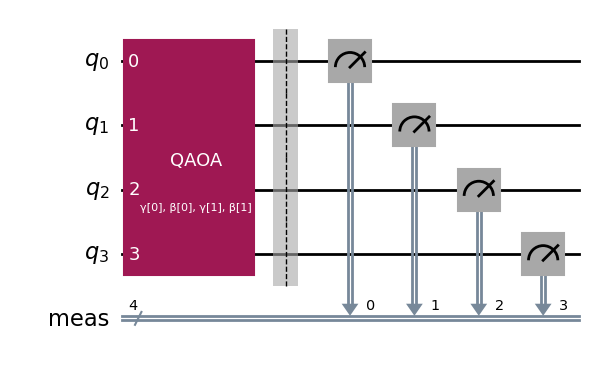

In [146]:
circuit = QAOAAnsatz(cost_operator=ising_hamiltonian, reps=reps)
circuit.measure_all()
circuit.draw('mpl')

In [147]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

In [148]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token=ibm_token, overwrite=True, set_as_default=True)

In [149]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
simulator = AerSimulator()

In [150]:
if (mode == "simulate"):
    backend = simulator
else:
    service = QiskitRuntimeService(channel='ibm_quantum')
    backend = service.least_busy(min_num_qubits=127)


In [151]:
print(backend)

AerSimulator('aer_simulator')


In [152]:
pm = generate_preset_pass_manager(optimization_level=3,backend=backend)
candidate_circuit = pm.run(circuit)
#candidate_circuit.draw('mpl', fold=False, idle_wires=False)


In [153]:
initial_gamma = np.pi
initial_beta = np.pi

init_params = []
for i in range(reps):
    init_params.append(initial_gamma)
    init_params.append(initial_beta)


In [154]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [155]:
objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, ising_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.835765199130869
       x: [ 3.232e+00  4.213e+00  3.134e+00  3.407e+00]
    nfev: 30
   maxcv: 0.0


/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have n

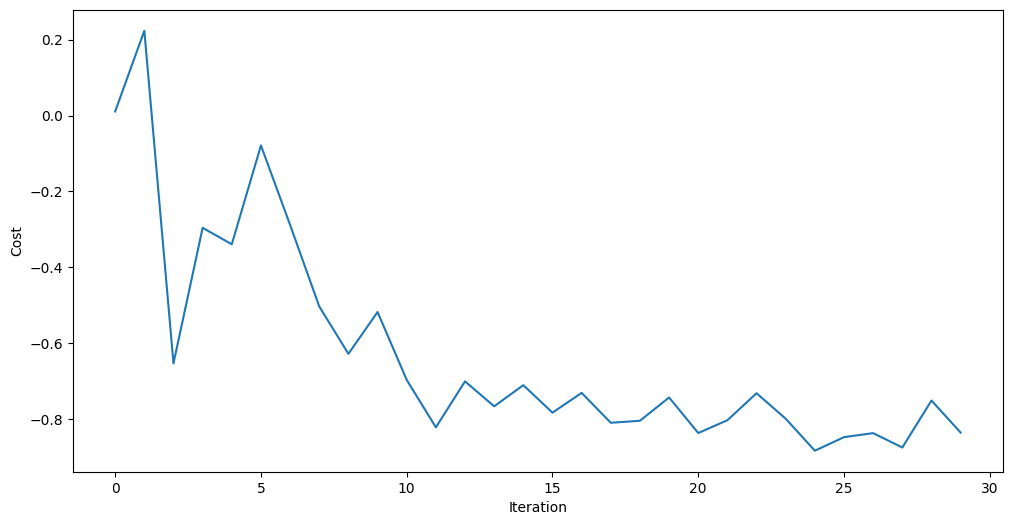

In [156]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [157]:
objective_func_vals

[array(0.01074566),
 array(0.22346022),
 array(-0.65344155),
 array(-0.29607817),
 array(-0.33938838),
 array(-0.07896509),
 array(-0.28835536),
 array(-0.50326629),
 array(-0.62817993),
 array(-0.5179442),
 array(-0.69679409),
 array(-0.82188405),
 array(-0.700736),
 array(-0.76645573),
 array(-0.7108113),
 array(-0.78315478),
 array(-0.73103579),
 array(-0.80987087),
 array(-0.80454922),
 array(-0.74320421),
 array(-0.83687398),
 array(-0.80315044),
 array(-0.73201664),
 array(-0.79914577),
 array(-0.88353769),
 array(-0.8477297),
 array(-0.83718691),
 array(-0.87506804),
 array(-0.75123118),
 array(-0.8357652)]

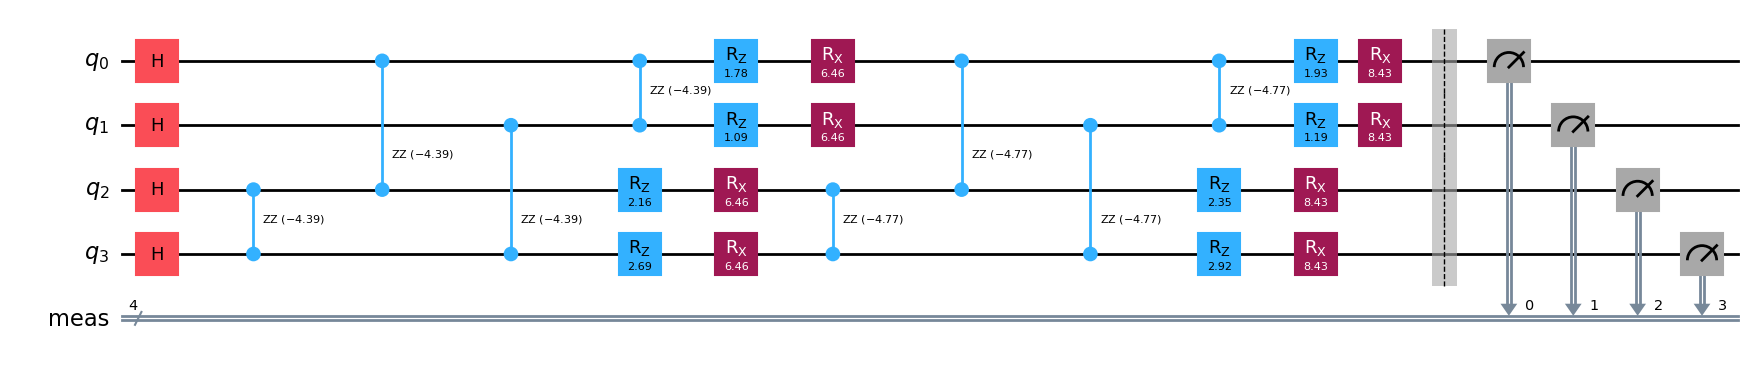

In [158]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [159]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{12: 0.1419, 8: 0.0341, 13: 0.3402, 15: 0.1177, 5: 0.1308, 7: 0.087, 9: 0.0404, 14: 0.0107, 11: 0.0123, 4: 0.0444, 0: 0.0232, 1: 0.0092, 3: 0.0027, 10: 0.0044, 6: 0.0006, 2: 0.0004}


/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [160]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, (n_rows * n_cols))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 1, 1]


[0.1419 0.0341 0.3402 0.1177 0.1308 0.087  0.0404 0.0107 0.0123 0.0444
 0.0232 0.0092 0.0027 0.0044 0.0006 0.0004]
[0.3402, 0.1419, 0.1308, 0.1177]


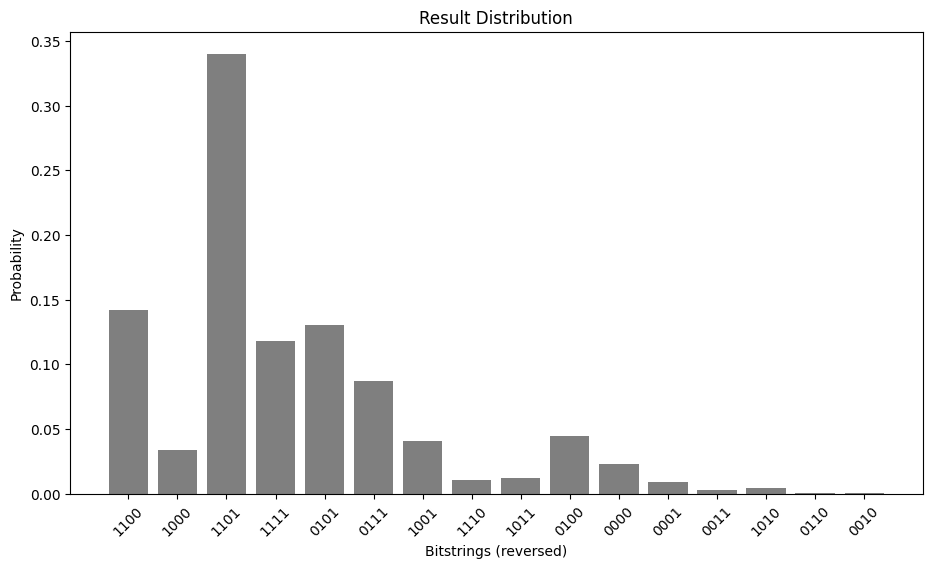

In [161]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
print(values)
top_4_values = sorted(values, reverse=True)[:4]
print(top_4_values)
positions = []

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

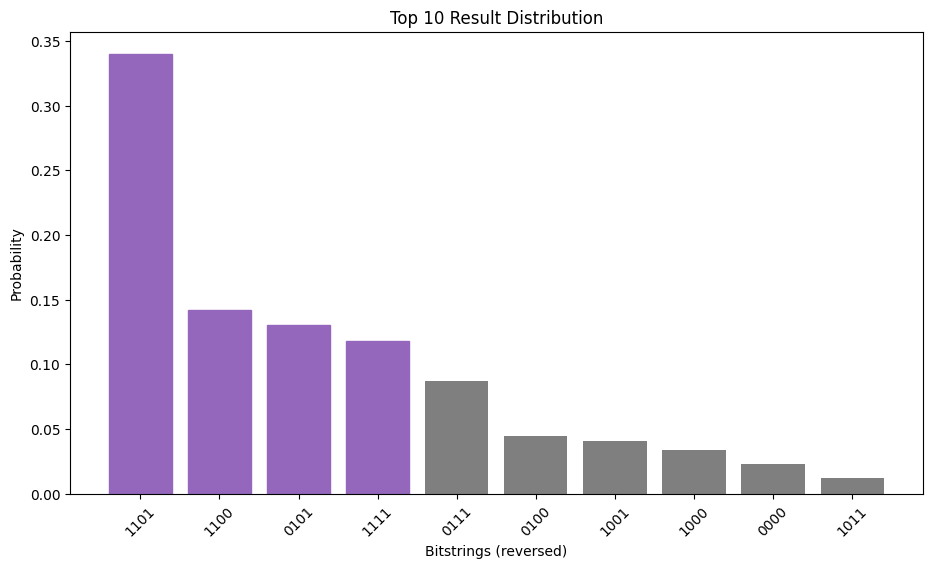

In [162]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming final_bits is a dictionary of bitstrings and their probabilities
final_bits = final_distribution_bin  # Replace this with your actual data

# Get the top 10 bitstrings by probability
sorted_bits = sorted(final_bits.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_keys = [k for k, _ in sorted_bits]
top_10_values = [v for _, v in sorted_bits]

# Get the indices of the top 4 probabilities
top_4_indices = sorted(range(len(top_10_values)), key=lambda i: top_10_values[i], reverse=True)[:4]

# Create the plot
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)

plt.xticks(rotation=45)
plt.title("Top 10 Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

# Bar plot for top 10 probabilities
bars = ax.bar(top_10_keys, top_10_values, color="tab:grey")

# Highlight the top 4 bars in purple
for i in top_4_indices:
    bars[i].set_color("tab:purple")

plt.show()


In [163]:
h

array([[-0.42900093, -0.34531477],
       [-0.1746655 , -0.28350231]])